In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/auto-insurance-claims-data/insurance_claims.csv


In [91]:
import pandas as pd
import numpy as np
import datetime as dt

#data viz
#for better viz
import plotly.express as px
import plotly.graph_objects as go

#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [92]:
df = pd.read_csv('/kaggle/input/auto-insurance-claims-data/insurance_claims.csv')
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


# EDA and cleaning

In [93]:
df.isnull().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

There are no null values in the dataset.

In [94]:
# removing column named _c39 as it contains only null values

df = df.drop(['_c39'], axis = 1)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

There doesn't seem to be need to change column data types except for `policy_bind_date` which we will convert to `datetime` type

In [96]:
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])

In [97]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,2.039540e+02,1.151132e+02,0.00,115.7500,199.5,276.250,479.00
age,1000.0,3.894800e+01,9.140287e+00,19.00,32.0000,38.0,44.000,64.00
policy_number,1000.0,5.462386e+05,2.570630e+05,100804.00,335980.2500,533135.0,759099.750,999435.00
policy_deductable,1000.0,1.136000e+03,6.118647e+02,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1.256406e+03,2.441674e+02,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,1.101000e+06,2.297407e+06,-1000000.00,0.0000,0.0,0.000,10000000.00
insured_zip,1000.0,5.012145e+05,7.170161e+04,430104.00,448404.5000,466445.5,603251.000,620962.00
capital-gains,1000.0,2.512610e+04,2.787219e+04,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-2.679370e+04,2.810410e+04,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,1.164400e+01,6.951373e+00,0.00,6.0000,12.0,17.000,23.00


In [98]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, ":", df[i].nunique())

policy_state : 3
policy_csl : 3
insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 20
insured_relationship : 6
incident_date : 60
incident_type : 4
collision_type : 4
incident_severity : 4
authorities_contacted : 5
incident_state : 7
incident_city : 7
incident_location : 1000
property_damage : 3
police_report_available : 3
auto_make : 14
auto_model : 39
fraud_reported : 2


We will drop some of the columns: `policy_state', 'policy_csl', 'incident_date', 'incident_state', 'incident_city' and 'incident_location`

In [99]:
drop_columns = ['policy_state', 'policy_csl', 'incident_date', 'incident_state', 'incident_city', 'incident_location']
df = df.drop(drop_columns, axis = 1)
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,1000,1406.91,0,466132,MALE,MD,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,2000,1197.22,5000000,468176,MALE,MD,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,2000,1413.14,5000000,430632,FEMALE,PhD,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,2000,1415.74,6000000,608117,FEMALE,PhD,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,1000,1583.91,6000000,610706,MALE,Associate,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [100]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, ":", df[i].nunique())

insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 20
insured_relationship : 6
incident_type : 4
collision_type : 4
incident_severity : 4
authorities_contacted : 5
property_damage : 3
police_report_available : 3
auto_make : 14
auto_model : 39
fraud_reported : 2


`fraud_reported` is going to be our target column. We will convert it to 1 and 0.

In [101]:
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)

In [102]:
df['fraud_reported'].unique()

array([1, 0])

`policy_deductable`: In an insurance policy, the deductible is the amount paid out of pocket by the policy holder before an insurance provider will pay any expenses.

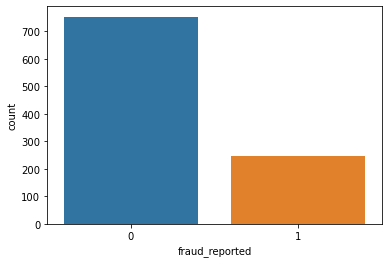

In [103]:
sns.countplot(df['fraud_reported'])

Our data is very imbalanced.

We will visualize the data and see if there is any feature which might influence the claims

In [104]:
def vis_data(df, x, y = 'fraud_reported', graph = 'countplot'):
    if graph == 'hist':
        fig = px.histogram(df, x = x)
        fig.update_layout(title = 'Distribution of {x}'.format(x = x))
        fig.show()
    elif graph == 'bar':
      fig = px.bar(df, x = x, y = y)
      fig.update_layout(title = '{x} vs. {y}'.format(x = x, y = y))
      fig.show()
    elif graph == 'countplot':
      a = df.groupby([x,y]).count()
      a.reset_index(inplace = True)
      no_fraud = a[a['fraud_reported'] == 0]
      yes_fraud = a[a['fraud_reported'] == 1]
      trace1 = go.Bar(x = no_fraud[x], y = no_fraud['policy_number'], name = 'No Fraud')
      trace2 = go.Bar(x = yes_fraud[x], y = yes_fraud['policy_number'], name = 'Fraud')
      fig = go.Figure(data = [trace1, trace2])
      fig.update_layout(title = '{x} vs. {y}'.format(x=x, y = y))
      fig.update_layout(barmode = 'group')
      fig.show()

In [105]:
vis_data(df, 'insured_sex')

In [106]:
vis_data(df, 'insured_education_level')

In [107]:
vis_data(df, 'insured_occupation')

From the data, it looks like people in exec-managerial positions have more number of frauds compared to other occupations.

Sales, tech-support and transport moving also have relatively high cases of fraud.

In [108]:
vis_data(df, 'insured_relationship')

In [109]:
vis_data(df, 'incident_type')

Multi-vehicle and single vehicle collisions have more number of frauds compared to parked and vehicle theft. One of the reasons could be that in a collision, there is high possibility of more damage to car, as well as the passengers and hence the need to file false insurance claims.

In [110]:
vis_data(df, 'collision_type')

While there are significant numbers of false claims in front and side collisions, rear collisions are the highest.

This data is for the US and there, many people use dash cams while driving to record whatever is happening while they drive. In rear collisions, the footage from dash cams is not very helpful to onclusively prove whose mistake it was (insurance owner or other car owner). Maybe that is the reason for more fradulent claims in rear collisions.

In [111]:
vis_data(df, 'incident_severity')

Here, compared to minor damage, total loss and trivial damage, fraudulent claims are highest in major damage.

One reason could be that the high amount of repair cost which will be incurred by the insurer due to major damage. 

In [112]:
vis_data(df, 'authorities_contacted')

In [113]:
vis_data(df, 'insured_hobbies')

One thing which is striking in this graph is that people with chess and cross-fit as hobby have extremely high number of fraudulent claims.

We will keep them and rename other values as 'other'

In [114]:
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['insured_hobbies'].unique()

array(['other', 'chess', 'cross-fit'], dtype=object)

In [115]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,1000,1406.91,0,466132,MALE,MD,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,2000,1197.22,5000000,468176,MALE,MD,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,2000,1413.14,5000000,430632,FEMALE,PhD,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,2000,1415.74,6000000,608117,FEMALE,PhD,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,1000,1583.91,6000000,610706,MALE,Associate,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


In [116]:
vis_data(df, 'age', 'anything', 'hist')

We will bin the ages and then check the trend for fraud vs. no fraud according to age.

In [117]:
df['age'].describe()

count    1000.000000
mean       38.948000
std         9.140287
min        19.000000
25%        32.000000
50%        38.000000
75%        44.000000
max        64.000000
Name: age, dtype: float64

In [118]:
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)

In [119]:
vis_data(df, 'age_group')

People in the age group of 31-35 and 41-45 have more number of frauds

In [120]:
vis_data(df, 'months_as_customer', 'not', 'hist')

Like we did for the age column, we will create a new column grouping the months_as_customer column data.

In [121]:
df['months_as_customer'].describe()

count    1000.000000
mean      203.954000
std       115.113174
min         0.000000
25%       115.750000
50%       199.500000
75%       276.250000
max       479.000000
Name: months_as_customer, dtype: float64

In [122]:
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)

In [123]:
vis_data(df, 'months_as_customer_groups')

In [124]:
vis_data(df, 'auto_make')

In [125]:
vis_data(df, 'number_of_vehicles_involved')

In [126]:
vis_data(df, 'witnesses', 'fraud_reported')

In [127]:
vis_data(df, 'bodily_injuries')

In [128]:
vis_data(df, 'total_claim_amount', 'y', 'hist')

In [129]:
vis_data(df, 'incident_hour_of_the_day')

In [130]:
vis_data(df, 'number_of_vehicles_involved')

In [131]:
vis_data(df, 'witnesses')

In [132]:
vis_data(df, 'auto_year')

In [133]:
df['policy_annual_premium'].describe()

count    1000.000000
mean     1256.406150
std       244.167395
min       433.330000
25%      1089.607500
50%      1257.200000
75%      1415.695000
max      2047.590000
Name: policy_annual_premium, dtype: float64

In [134]:
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)

In [135]:
vis_data(df, 'policy_annual_premium_groups')


In [136]:
df['policy_deductable'].describe()

count    1000.000000
mean     1136.000000
std       611.864673
min       500.000000
25%       500.000000
50%      1000.000000
75%      2000.000000
max      2000.000000
Name: policy_deductable, dtype: float64

In [137]:
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

vis_data(df, 'policy_deductable_group')

In [138]:
vis_data(df, 'property_damage')

In [139]:
vis_data(df, 'police_report_available')

In [140]:
#removing columns for which we created groups
df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
df.columns

Index(['policy_number', 'policy_bind_date', 'umbrella_limit', 'insured_zip',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group'],
      dtype='object')

Based on the EDA, we remove some of the columns

In [141]:
required_columns = ['policy_number', 'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'capital-gains', 'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'witnesses', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim',
       'fraud_reported', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups']

print(len(required_columns))

22


In [142]:
df1 = df[required_columns]

corr_matrix = df1.corr()

fig = go.Figure(data = go.Heatmap(
                                z = corr_matrix.values,
                                x = list(corr_matrix.columns),
                                y = list(corr_matrix.index)))

fig.update_layout(title = 'Correlation')

fig.show()

From the correlation matrix, we see there is high correlation between `vehicle claim`, `total_claim_amount`, `property_claim` and `injury_claim`

The reason for it is that `total_claim_amount` is the sum of columns `vehicle claim`,`property_claim` and `injury_claim`.

We will remove the other 3 columns and only keep `total_claim_amount` as it captures the information and removes collinearity.

In [143]:
t = df['total_claim_amount'].iloc[1]
a = df['vehicle_claim'].iloc[1]
b = df['property_claim'].iloc[1]
c = df['injury_claim'].iloc[1]

print(t)
a+b+c

5070


5070

Keeping only the `total_claim_amount` column from these.

In [144]:
required_columns = ['insured_sex', 'insured_occupation',
       'insured_hobbies', 'capital-gains', 'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'witnesses', 'total_claim_amount', 'fraud_reported', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups']

print(len(required_columns))

17


In [145]:
df1 = df1[required_columns]
df1.head()

,insured_sex,insured_occupation,insured_hobbies,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,age_group,months_as_customer_groups,policy_annual_premium_groups
0,MALE,craft-repair,other,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,5,1,2,71610,1,46-50,301-350,medium
1,MALE,machine-op-inspct,other,0,0,Vehicle Theft,?,Minor Damage,Police,8,1,0,5070,1,41-45,201-250,medium
2,FEMALE,sales,other,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,7,3,3,34650,0,26-30,101-150,medium
3,FEMALE,armed-forces,other,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,5,1,2,63400,1,41-45,251-300,medium
4,MALE,sales,other,66000,-46000,Vehicle Theft,?,Minor Damage,None,20,1,1,6500,0,41-45,201-250,high


## Encoding data for modelling

In [146]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups']
for col in cat_cols:
  df1[col] = df1[col].astype('object')

columns_to_encode = []
for col in df1.columns:
  if df1[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode

['insured_sex',
 'insured_occupation',
 'insured_hobbies',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups']

In [147]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   insured_sex                   1000 non-null   object
 1   insured_occupation            1000 non-null   object
 2   insured_hobbies               1000 non-null   object
 3   capital-gains                 1000 non-null   int64 
 4   capital-loss                  1000 non-null   int64 
 5   incident_type                 1000 non-null   object
 6   collision_type                1000 non-null   object
 7   incident_severity             1000 non-null   object
 8   authorities_contacted         1000 non-null   object
 9   incident_hour_of_the_day      1000 non-null   int64 
 10  number_of_vehicles_involved   1000 non-null   int64 
 11  witnesses                     1000 non-null   int64 
 12  total_claim_amount            1000 non-null   int64 
 13  fraud_reported     

In [148]:
df1.head()

,insured_sex,insured_occupation,insured_hobbies,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,age_group,months_as_customer_groups,policy_annual_premium_groups
0,MALE,craft-repair,other,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,5,1,2,71610,1,46-50,301-350,medium
1,MALE,machine-op-inspct,other,0,0,Vehicle Theft,?,Minor Damage,Police,8,1,0,5070,1,41-45,201-250,medium
2,FEMALE,sales,other,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,7,3,3,34650,0,26-30,101-150,medium
3,FEMALE,armed-forces,other,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,5,1,2,63400,1,41-45,251-300,medium
4,MALE,sales,other,66000,-46000,Vehicle Theft,?,Minor Damage,None,20,1,1,6500,0,41-45,201-250,high


In [149]:
df2 = pd.get_dummies(df1, columns = columns_to_encode)

df2.head()

,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,insured_sex_FEMALE,insured_sex_MALE,insured_occupation_adm-clerical,...,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low
0,53300,0,5,1,2,71610,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,0,0,8,1,0,5070,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,35100,0,7,3,3,34650,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,48900,-62400,5,1,2,63400,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,66000,-46000,20,1,1,6500,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


## Features and Target

In [150]:
features = []
for col in df2.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df2[features]
y = df2[target]

## Scaling

In [151]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

# Modelling

## Splitting in train and test data

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

## Logistic Regression

In [153]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
preds = lr.predict(X_test)

score = lr.score(X_test, y_test)
print(score)

0.848


In [154]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       180
           1       0.78      0.64      0.70        70

    accuracy                           0.85       250
   macro avg       0.82      0.79      0.80       250
weighted avg       0.84      0.85      0.84       250



## Synthetic Minority Over-sampling Technique (SMOTE)

We saw that our data is not balanced. Therefore, we will apply SMOTE and then predict.

In [155]:
oversample = SMOTE(random_state=9)

In [156]:
X_over, y_over = oversample.fit_resample(X, y)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state = 1)

We will use the LogisticRegression we defined earlier

In [158]:
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)
print()
print(classification_report(y_test, preds))

0.8514588859416445

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       201
           1       0.82      0.88      0.85       176

    accuracy                           0.85       377
   macro avg       0.85      0.85      0.85       377
weighted avg       0.85      0.85      0.85       377



### The accuracy increased from 84.8% to **85.1%**

## Decision Tree

In [159]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)

score = dtc.score(X_test, y_test)
print(score)
print()
print(classification_report(y_test, preds))

0.8514588859416445

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       201
           1       0.83      0.86      0.84       176

    accuracy                           0.85       377
   macro avg       0.85      0.85      0.85       377
weighted avg       0.85      0.85      0.85       377



## There is some more increase in accuracy

In [160]:
from sklearn.ensemble import RandomForestClassifier

## Random Forest

In [161]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [162]:
preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

90.18567639257294

              precision    recall  f1-score   support

           0       0.95      0.87      0.90       201
           1       0.86      0.94      0.90       176

    accuracy                           0.90       377
   macro avg       0.90      0.90      0.90       377
weighted avg       0.91      0.90      0.90       377



## Using Random Forest, we got an accuracy of 90.18%.
We were able to increase our model accuracy from 84.8% to over 90%.

We will see if we can increase it further using hyperparameter tuning.

# Hyperparameter Tuning

In [163]:
rfc_tuned = RandomForestClassifier(n_estimators = 1000, random_state = 1, min_samples_split = 2)
rfc_tuned.fit(X_train, y_train)
preds_tuned = rfc_tuned.predict(X_test)
score = rfc_tuned.score(X_test, y_test)
print(score)

0.8912466843501327


There was no improvement. We will use GridSearch to check for the best parameters ad use them for tuning.

## GridSearch

In [164]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyper = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfc, hyper, cv = 3, verbose = 1, 
                      n_jobs = -1)
best = grid.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 14.8min finished


In [165]:
print(best)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                   

Using the best parameters from GridSearch

In [167]:
rfc_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False)

rfc_tuned.fit(X_train, y_train)
preds_tuned = rfc_tuned.predict(X_test)

score = rfc_tuned.score(X_test, y_test)

print(score)

0.9018567639257294


# Conclusion

## Using GridSearch method also we got accuracy of 90.18%.

We were able to increase our accuracy from 84% to over 90% using data cleaning, feature engineering, feature selection and hyperparameter tuning.

### Upvote and like if you find it useful  